In [1]:
## Prework: Stage Environment

import csv
import pydot
import pydotplus
import warnings
import numpy as np
import pandas as pd
import graphviz as gv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
## INTRODUCTORY NOTE: Our dataset is a selection of thirteen variables from a dataset containing hundreds. My computer kept crashing when I tried to load all the original Excel files for the purposes of isolating and combining the variables of interest which spread across multiple files, so I pulled out the variables of interest from the original datasets and re-combined them into the reference .csv.
## Load Initial Dataset
filename = 'S1month.csv'

## Create set variants & clean the data
# Complete, unmodified dataset
Allmonthraw = pd.read_csv(filename)

# Modified Dataset 1: Skip pattern present in variable S#PROJUS_PJPNUM edited to reflect accurate instances of police contact (i.e., '0'); other skip-patterns replaced to reflect missing values
Allmonth = pd.read_csv(filename, na_values = [-202, -201, -700, -300, -9, -8])
Allmonth = Allmonth.replace({'S1PROJUS_PJPNUM': -101,
                            'S6PROJUS_PJPNUM': -101,
                            'SAPROJUS_PJPNUM': -101}, 0)
## The na_values indicate the following:
##      -202: Partial interview, data missing
##      -201: Missed interview
##      -101: Not picked up by police during recall period
##      -700: Data missing due to bug in interview
##      -300: Too few answers for computation 
##      -9: Didn't Know
##      -8: Refused

# Modified Dataset 2: All 'NA' values dropped from observations.
AllmonthNA = Allmonth.dropna()

# Modified Dataset 3: Collapsing observations for the purposes of predictive modeling
AllcollapseNA = AllmonthNA.replace({'S1PROJUS_PJPNUM': {5 : 4, 6 : 4, 7 : 4},
                                   'S6PROJUS_PJPNUM': {5 : 4, 6 : 4, 7 : 4},
                                   'SAPROJUS_PJPNUM': {5 : 4, 6 : 4, 15 : 4}})

# Modified Dataset 5: Creating Select Models for Police Contact
S1PolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.S1PROJUS_PJPOLI == 0].index)
S1PolConOnly = S1PolConOnlyraw.dropna()
S6PolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.S6PROJUS_PJPOLI == 0].index)
S6PolConOnly = S6PolConOnlyraw.dropna()
SAPolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.SAPROJUS_PJPOLI == 0].index)
SAPolConOnly = SAPolConOnlyraw.dropna()

In [3]:
# Generating table of summary statistics for all items in dataset
Summarystats = Allmonth.drop(['CASEID', 'LINEID'], axis=1)
Summarystats.describe()

,S0NEARPRO,S1PROJUS_PJPOLI,S1PROJUS_PJPNUM,S1PSMI,S1EXPTOT,S6PROJUS_PJPOLI,S6PROJUS_PJPNUM,S6PSMI,S6EXPTOT,SAPROJUS_PJPOLI,SAPROJUS_PJPNUM,SAPSMI,SAEXPTOT
count,1354.000000,1260.000000,1261.000000,1258.000000,1261.000000,1232.000000,1232.000000,1227.000000,1232.000000,1132.000000,1132.000000,1129.000000,1131.000000
mean,1.519941,0.183333,0.240285,3.055199,1.448057,0.200487,0.253247,3.203431,0.902597,0.224382,0.303004,3.284925,1.088417
std,1.191235,0.387093,0.616051,0.462735,1.894404,0.400527,0.593073,0.455841,1.525391,0.417359,0.771434,0.423084,1.665676
min,0.000000,0.000000,0.000000,1.100000,0.000000,0.000000,0.000000,1.830000,0.000000,0.000000,0.000000,1.200000,0.000000
25%,1.000000,0.000000,0.000000,2.770000,0.000000,0.000000,0.000000,2.870000,0.000000,0.000000,0.000000,2.970000,0.000000
50%,1.000000,0.000000,0.000000,3.030000,1.000000,0.000000,0.000000,3.170000,0.000000,0.000000,0.000000,3.300000,0.000000
75%,2.000000,0.000000,0.000000,3.400000,2.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,3.630000,2.000000
max,5.000000,1.000000,7.000000,4.000000,10.000000,1.000000,5.000000,4.000000,10.000000,1.000000,15.000000,4.000000,10.000000


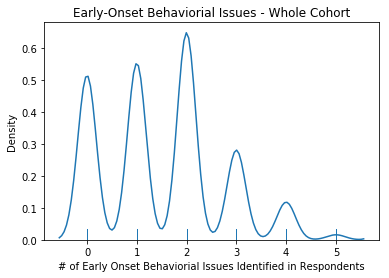

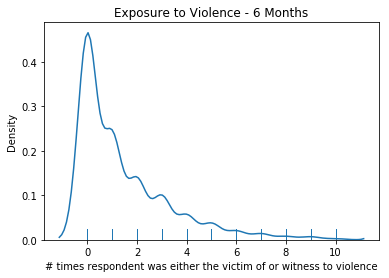

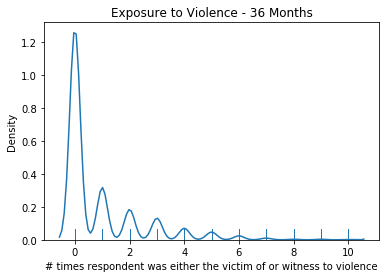

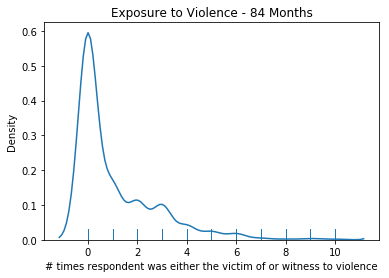

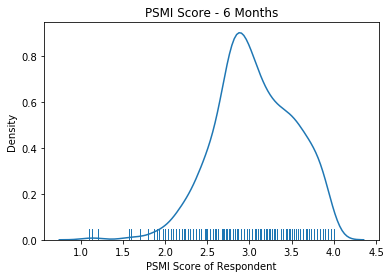

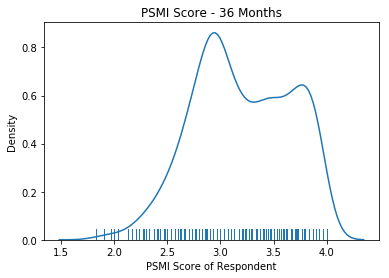

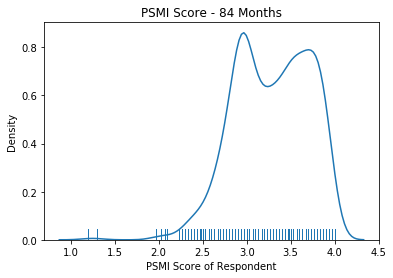

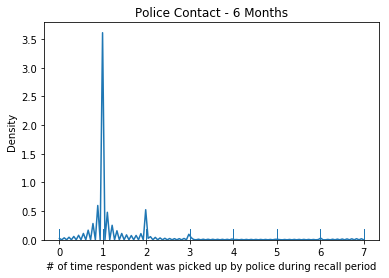

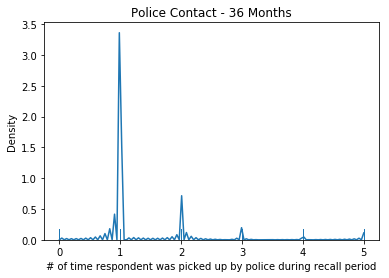

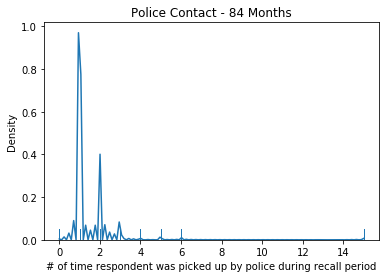

In [4]:
## Distribution of Variables: Distribution Plots

# Define function to generate distribution plots for a given variable
def distplotgen(variable, xlabel, title):
    variable_clean = variable.dropna()
    sns.distplot(variable_clean, hist=False, rug=True);
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
    plt.show()

#Early-Onset Behavioral Issues
distplotgen(Allmonth.S0NEARPRO, "# of Early Onset Behaviorial Issues Identified in Respondents", "Early-Onset Behaviorial Issues - Whole Cohort")

#Exposure to Violence
distplotgen(Allmonth.S1EXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 6 Months")
distplotgen(Allmonth.S6EXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 36 Months")
distplotgen(Allmonth.SAEXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 84 Months")

#Psychosocial Maturity
distplotgen(Allmonth.S1PSMI, "PSMI Score of Respondent", "PSMI Score - 6 Months")
distplotgen(Allmonth.S6PSMI, "PSMI Score of Respondent", "PSMI Score - 36 Months")
distplotgen(Allmonth.SAPSMI, "PSMI Score of Respondent", "PSMI Score - 84 Months")

#Police Contact
distplotgen(Allmonth.S1PROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 6 Months")
distplotgen(Allmonth.S6PROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 36 Months")
distplotgen(Allmonth.SAPROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 84 Months")

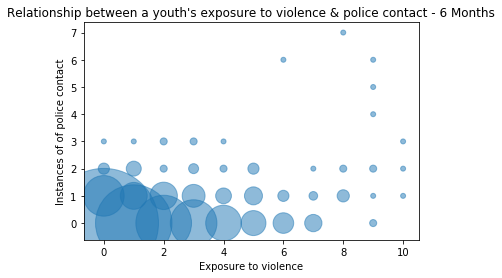

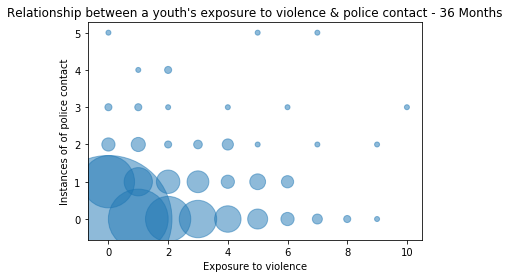

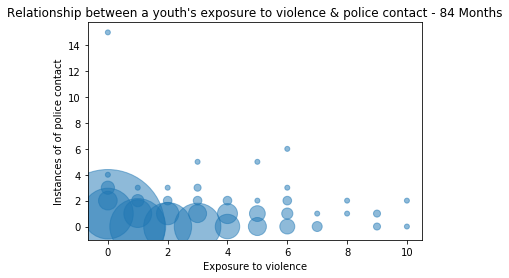

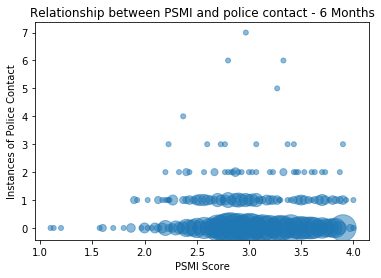

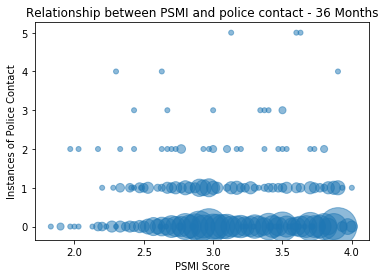

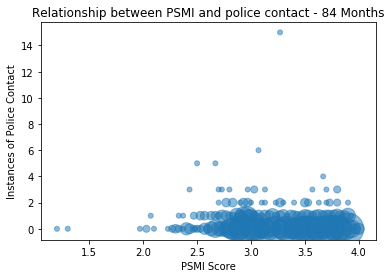

In [5]:
## Bubble Plots

# Define function to create bubble plots
def bubbleplot(df, variable1, variable2, xlabel, ylabel, title):
    count = 0
    x_vals = []
    y_vals = []
    bsize = []
    for i in variable1.unique():
        for j in variable2.unique():
            bubblesize = len(df[(variable1 == i) & (variable2 == j)])
            count += bubblesize
            x_vals.append(i)
            y_vals.append(j)
            bsize.append(bubblesize)
    bsizescale = [n*25 for n in bsize]
    plt.scatter(x_vals, y_vals, s=bsizescale, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
# Bubbleplots testing for correlation between exposure to violence & police contact
bubbleplot(Allmonth, Allmonth.S1EXPTOT, Allmonth.S1PROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between a youth's exposure to violence & police contact - 6 Months")
bubbleplot(Allmonth, Allmonth.S6EXPTOT, Allmonth.S6PROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between a youth's exposure to violence & police contact - 36 Months")
bubbleplot(Allmonth, Allmonth.SAEXPTOT, Allmonth.SAPROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between a youth's exposure to violence & police contact - 84 Months")


# Bubbleplots testing for correlation between PSMI and police contact
bubbleplot(Allmonth, Allmonth.S1PSMI, Allmonth.S1PROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 6 Months")
bubbleplot(Allmonth, Allmonth.S6PSMI, Allmonth.S6PROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 36 Months")
bubbleplot(Allmonth, Allmonth.SAPSMI, Allmonth.SAPROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 84 Months")



In [6]:
## Predictive Modeling Prework: KNN Classification Model

# Creating a Feature Matrix & Target Array for 6-Month Cohort
XvaluesS1 = AllcollapseNA.drop(['CASEID', 'LINEID',
                                'S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI', 
                                'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT',
                                'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConS1 = AllcollapseNA.S1PROJUS_PJPNUM

# QA: print('X shape:', XvaluesS1.shape, '\ny shape:', PolConS1.shape)

# Converting y values to string type variable
PolConS1 = PolConS1.astype(str)

## Testing for appropriate value of k and generating accuracy scores
#  Defining a function to test for optimal k-value and accuracy score generator
def kvaluecv(list_of_k, cvfold, xparam, yparam):
    for k in list_of_k:
        KNN = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(KNN, xparam, yparam, cv=cvfold)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

kvaluecv([1, 3, 5, 7, 10], 3, XvaluesS1, PolConS1)

# Create & fit the model for the 6-month cohort using appropriate k value
KNNmodelS1 = KNeighborsClassifier(n_neighbors=5)

KNNmodelS1.fit(XvaluesS1, PolConS1)

Accuracy: 0.68 (+/- 0.03)
Accuracy: 0.77 (+/- 0.05)
Accuracy: 0.78 (+/- 0.04)
Accuracy: 0.81 (+/- 0.02)
Accuracy: 0.81 (+/- 0.01)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [7]:
## Predictive Modeling Prework: KNN Classification Model

#Creating Feature Matrix & Target Array for 36-Month Cohort
XvaluesS6 = AllcollapseNA.drop(['CASEID', 'LINEID',
                                'S6PROJUS_PJPNUM', 'S6PROJUS_PJPOLI', 
                                'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT',
                                'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConS6 = AllcollapseNA.S6PROJUS_PJPNUM

# QA: print('X shape:', XvaluesS6.shape, '\ny shape:', PolConS6.shape)

#Converting y values to string type variable
PolConS6 = PolConS6.astype(str)

## KNN Classification Model -- Testing for appropriate value of k and generating accuracy scores
kvaluecv([1, 3, 5, 7, 10], 3, XvaluesS6, PolConS6)

# Create & fit the model using appropriate k value
KNNmodelS6 = KNeighborsClassifier(n_neighbors=5)

KNNmodelS6.fit(XvaluesS6, PolConS6)

Accuracy: 0.70 (+/- 0.01)
Accuracy: 0.76 (+/- 0.04)
Accuracy: 0.79 (+/- 0.02)
Accuracy: 0.80 (+/- 0.00)
Accuracy: 0.80 (+/- 0.01)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
## Predictive Modeling Prework: KNN Classification Model
# Creating Feature Matrix & Target Array for 36-Month Cohort

XvaluesSA = AllcollapseNA.drop(['CASEID', 'LINEID',
                                'SAPROJUS_PJPNUM', 'SAPROJUS_PJPOLI', 
                                'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT',
                                'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT'], axis=1)
PolConSA = AllcollapseNA.S6PROJUS_PJPNUM

# QA: print('X shape:', XvaluesSA.shape, '\ny shape:', PolConSA.shape)

# Converting y values to string type variable
PolConSA = PolConSA.astype(str)

# Testing for appropriate value of k and generating accuracy scores

kvaluecv([1, 3, 5, 7, 10], 3, XvaluesSA, PolConSA)

# Create & fit the model using appropriate k value

KNNmodelSA = KNeighborsClassifier(n_neighbors=5)

KNNmodelSA.fit(XvaluesSA, PolConSA)

Accuracy: 0.67 (+/- 0.01)
Accuracy: 0.77 (+/- 0.04)
Accuracy: 0.81 (+/- 0.01)
Accuracy: 0.80 (+/- 0.01)
Accuracy: 0.81 (+/- 0.01)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [9]:
## Decision Tree Model
# Create & fit the model for 6-month cohort

TreemodelS1 = tree.DecisionTreeClassifier()

TreemodelS1.fit(XvaluesS1, PolConS1)

# 36-month cohort
TreemodelS6 = tree.DecisionTreeClassifier()

TreemodelS6.fit(XvaluesS6, PolConS6)

# 84-month cohort
TreemodelSA = tree.DecisionTreeClassifier()

TreemodelSA.fit(XvaluesSA, PolConSA)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
## Decision Tree Model
# Test Accuracy of 6-month model via Cross-Validation

def crossvaltest(model, featurevar, targetvar, cvfold):
    scores = cross_val_score(model, featurevar, targetvar, cv=cvfold)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

crossvaltest(TreemodelS1, XvaluesS1, PolConS1, 3)

Accuracy: 0.71 (+/- 0.04)


In [11]:
## Decision Tree Model
# Test Accuracy of 36-month model

crossvaltest(TreemodelS6, XvaluesS6, PolConS6, 3)

Accuracy: 0.71 (+/- 0.03)


In [12]:
## Decision Tree Model
# Test Accuracy of 84-month model

crossvaltest(TreemodelSA, XvaluesSA, PolConSA, 3)

Accuracy: 0.71 (+/- 0.02)


In [13]:
# Create Random Forest Model - 6 month cohort
RandommodelS1 = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelS1.fit(XvaluesS1, PolConS1)

# 36 months
RandommodelS6 = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelS6.fit(XvaluesS6, PolConS6)

# 84 months
RandommodelSA = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelSA.fit(XvaluesSA, PolConSA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [14]:
# Test 
crossvaltest(RandommodelS1, XvaluesS1, PolConS1, 3)
crossvaltest(RandommodelS6, XvaluesS6, PolConS6, 3)
crossvaltest(RandommodelSA, XvaluesSA, PolConSA, 3)

Accuracy: 0.74 (+/- 0.02)
None
Accuracy: 0.75 (+/- 0.03)
None
Accuracy: 0.74 (+/- 0.04)
None


In [15]:
# Create visualization of random example tree from Random Forest model

tree.export_graphviz(RandommodelS1.estimators_[0], out_file='RFtree.dot')
(graph,) = pydot.graph_from_dot_file('RFtree.dot')
graph.write_png('RFtree.png')

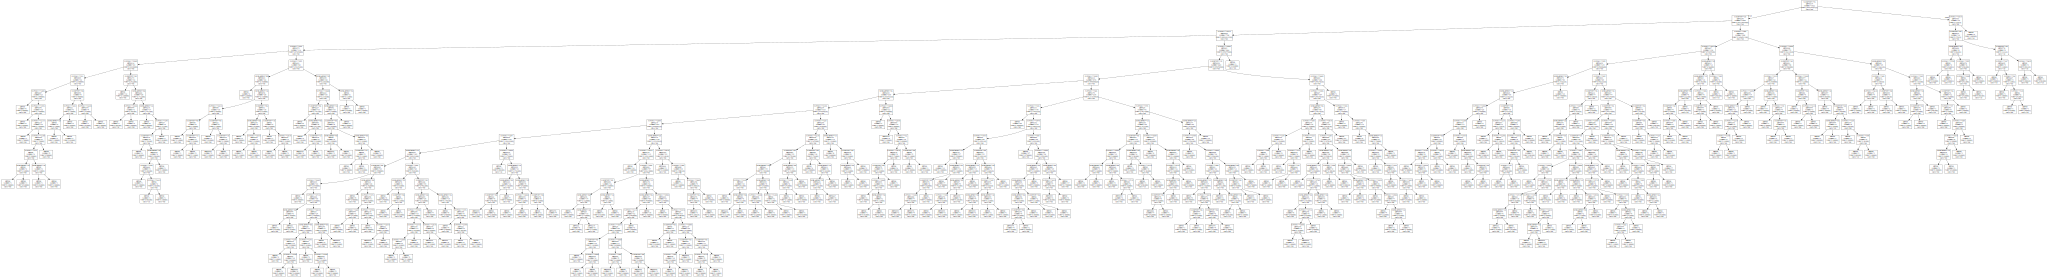

In [16]:
## Decision Tree Model
# Create Visualization of Decision Tree - 6-month cohort

# def treeplot(model, xvar, yvar, GraphName):
#    dot_data = tree.export_graphviz(model, out_file = None, 
#                                    feature_names = xvar.columns, 
#                                    class_names = yvar)
#    graph = gv.Source(dot_data)
#    graph.render(GraphName)
#    graph
# treeplot(TreemodelS1, XvaluesS1, PolConS1, "OriginalModelS1")

dot_data = tree.export_graphviz(TreemodelS1, out_file=None,
                              feature_names=XvaluesS1.columns,
                              class_names=PolConS1)
graph = gv.Source(dot_data)
graph.render("OriginalModelS1")
graph

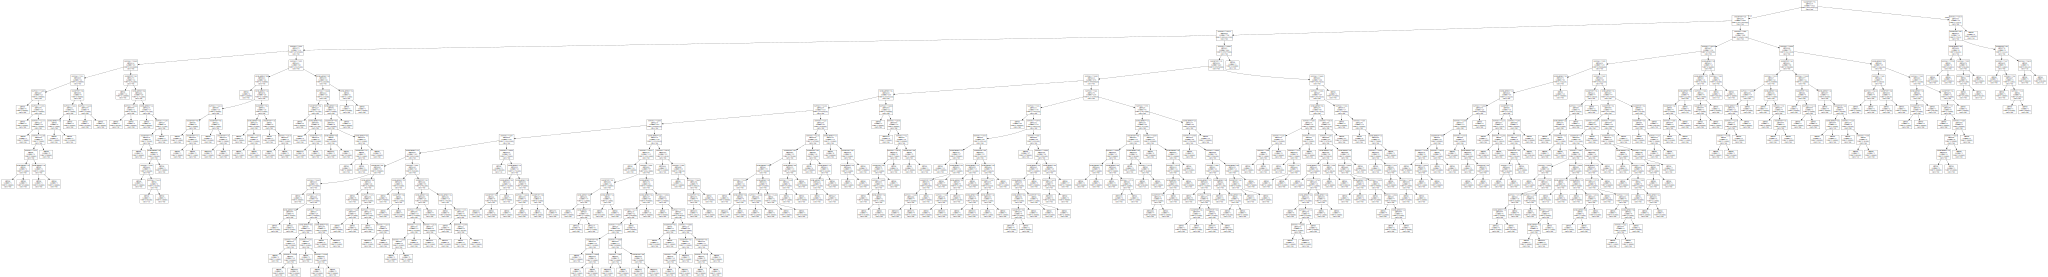

In [17]:
## Decision Tree Model
# Create Visualization of Decision Tree - 36-month cohort

dot_data = tree.export_graphviz(TreemodelS1, out_file=None,
                              feature_names=XvaluesS6.columns,
                              class_names=PolConS6)
graph = gv.Source(dot_data)
graph.render("OriginalModelS6")
graph

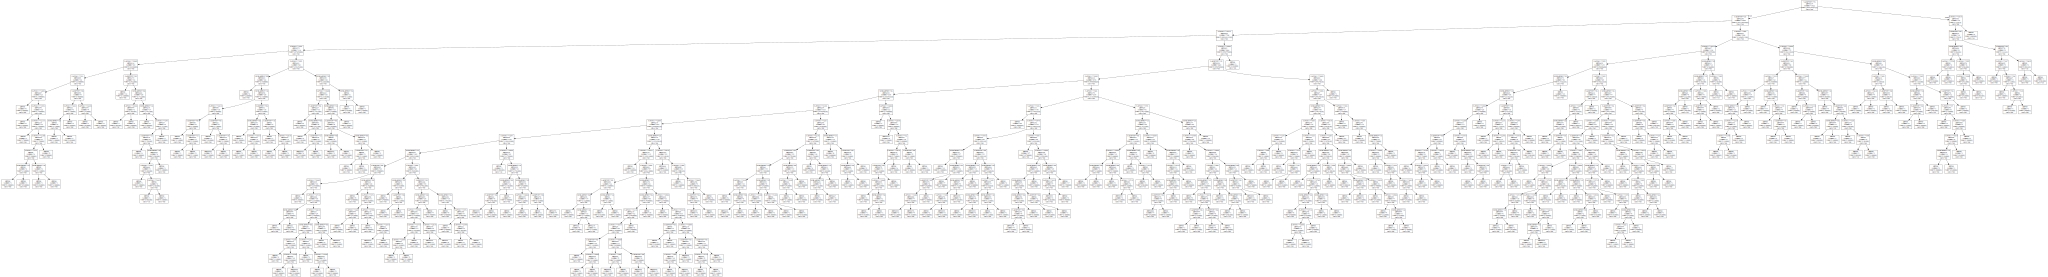

In [18]:
## Decision Tree Model
# Create Visualization of Decision Tree - 84-month cohort

dot_data = tree.export_graphviz(TreemodelS1, out_file=None,
                               feature_names=XvaluesSA.columns,
                               class_names=PolConSA)
graph = gv.Source(dot_data)
graph.render("OriginalModelSA")
graph

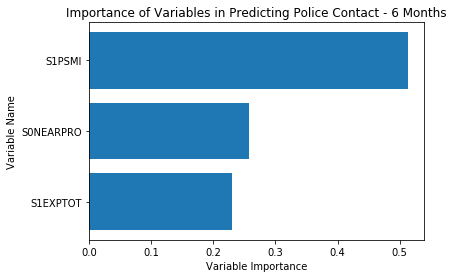

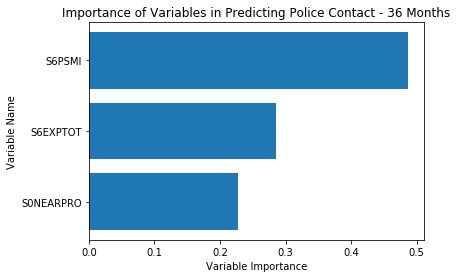

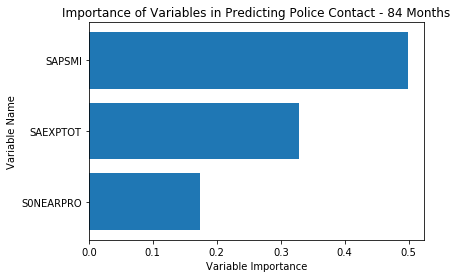

In [19]:
## Feature Importances
# Define function to generate feature importances

def featimpbar(model, featurevar, title):
    # Generate Feature Importance Values
    Vdf_dict = dict(zip(featurevar.columns, model.feature_importances_))
    # Create DataFrame using values
    Vdf = pd.DataFrame.from_dict(Vdf_dict, orient = 'index')
    Vdf['VarName'] = Vdf.index
    Vdf.columns = 'Importance', 'Name'
    Vdf = Vdf.sort_values(by=['Importance', 'Name'])
    # Make barplot for feature importances
    plt.figure()
    plt.barh(Vdf.Name, Vdf.Importance)
    plt.xlabel('Variable Importance')
    plt.ylabel('Variable Name')
    plt.title(title)


# Barplot for full models
featimpbar(TreemodelS1, XvaluesS1, 'Importance of Variables in Predicting Police Contact - 6 Months')
featimpbar(TreemodelS6, XvaluesS6, 'Importance of Variables in Predicting Police Contact - 36 Months')
featimpbar(TreemodelSA, XvaluesSA, 'Importance of Variables in Predicting Police Contact - 84 Months')

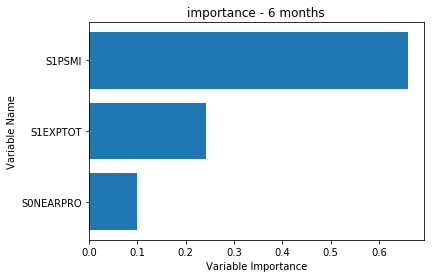

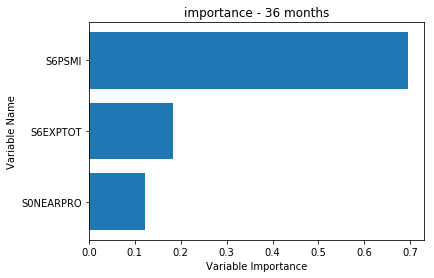

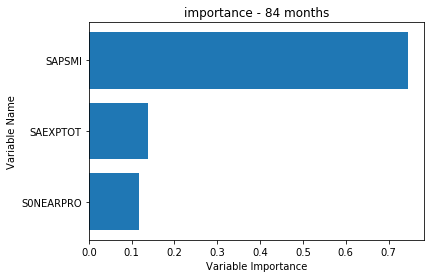

In [20]:
# Feature Importance Graphs of Random Forest model - General cohort
featimpbar(RandommodelS1, XvaluesS1, 'importance - 6 months')
featimpbar(RandommodelS6, XvaluesS6, 'importance - 36 months')
featimpbar(RandommodelSA, XvaluesSA, 'importance - 84 months')

In [21]:
## Target Array and Feature Matrices for Police Contact Sample Only ("Select Model")

# 6-month cohort
XselectS1 = S1PolConOnlyraw.drop(['CASEID', 'LINEID','S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI', 
                               'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT', 
                               'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConSelectS1 = S1PolConOnlyraw.S1PROJUS_PJPNUM
PolConSelectS1 = PolConSelectS1.astype(str)
print('X shape:', XselectS1.shape, '\ny shape:', PolConSelectS1.shape)

# 36-month cohort
XselectS6 = S6PolConOnlyraw.drop(['CASEID', 'LINEID','S6PROJUS_PJPNUM', 'S6PROJUS_PJPOLI', 
                               'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT', 
                               'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConSelectS6 = S6PolConOnlyraw.S6PROJUS_PJPNUM
PolConSelectS6 = PolConSelectS6.astype(str)
print('X shape:', XselectS6.shape, '\ny shape:', PolConSelectS6.shape)

# 84-month cohort
XselectSA = SAPolConOnlyraw.drop(['CASEID', 'LINEID','SAPROJUS_PJPNUM', 'SAPROJUS_PJPOLI', 
                               'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT', 
                               'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT'], axis=1)
PolConSelectSA = SAPolConOnlyraw.SAPROJUS_PJPNUM
PolConSelectSA = PolConSelectSA.astype(str)
print('X shape:', XselectSA.shape, '\ny shape:', PolConSelectSA.shape)

X shape: (190, 3) 
y shape: (190,)
X shape: (196, 3) 
y shape: (196,)
X shape: (227, 3) 
y shape: (227,)


In [22]:
## Decision Tree Select Model - 6-month cohort
selectmodelS1 = tree.DecisionTreeClassifier()
selectmodelS1.fit(XselectS1, PolConSelectS1)

# 36-month cohort
selectmodelS6 = tree.DecisionTreeClassifier()
selectmodelS6.fit(XselectS6, PolConSelectS6)

# 84-month cohort
selectmodelSA = tree.DecisionTreeClassifier()
selectmodelSA.fit(XselectSA, PolConSelectSA)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
## Cross-Validation & Accuracy Score for Select Models

# 6-month
crossvaltest(selectmodelS1, XselectS1, PolConSelectS1, 3)

# 36-month
crossvaltest(selectmodelS6, XselectS6, PolConSelectS6, 3)

crossvaltest(selectmodelSA, XselectSA, PolConSelectSA, 3)

Accuracy: 0.69 (+/- 0.04)
Accuracy: 0.75 (+/- 0.06)
Accuracy: 0.67 (+/- 0.06)


In [24]:
## Random Forest Modeling for Select Model
# 6-month cohort

randomselectS1 = RandomForestClassifier()
randomselectS1.fit(XselectS1, PolConSelectS1)

# 36-month
randomselectS6 = RandomForestClassifier()
randomselectS6.fit(XselectS6, PolConSelectS6)

# 84-month
randomselectSA = RandomForestClassifier()
randomselectSA.fit(XselectSA, PolConSelectSA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
## Cross-Validation & Accuracy Score for Select RF Models

# 6-month
crossvaltest(randomselectS1, XselectS1, PolConSelectS1, 3)

# 36-month
crossvaltest(randomselectS6, XselectS6, PolConSelectS6, 3)

crossvaltest(randomselectSA, XselectSA, PolConSelectSA, 3)

Accuracy: 0.78 (+/- 0.03)
Accuracy: 0.79 (+/- 0.04)
Accuracy: 0.75 (+/- 0.07)


In [26]:
## Rendering of Example Tree from Random Forest Model

tree.export_graphviz(randomselectS1.estimators_[0], out_file='RStree.dot')
(graph,) = pydot.graph_from_dot_file('RStree.dot')
graph.write_png('RStree.png')


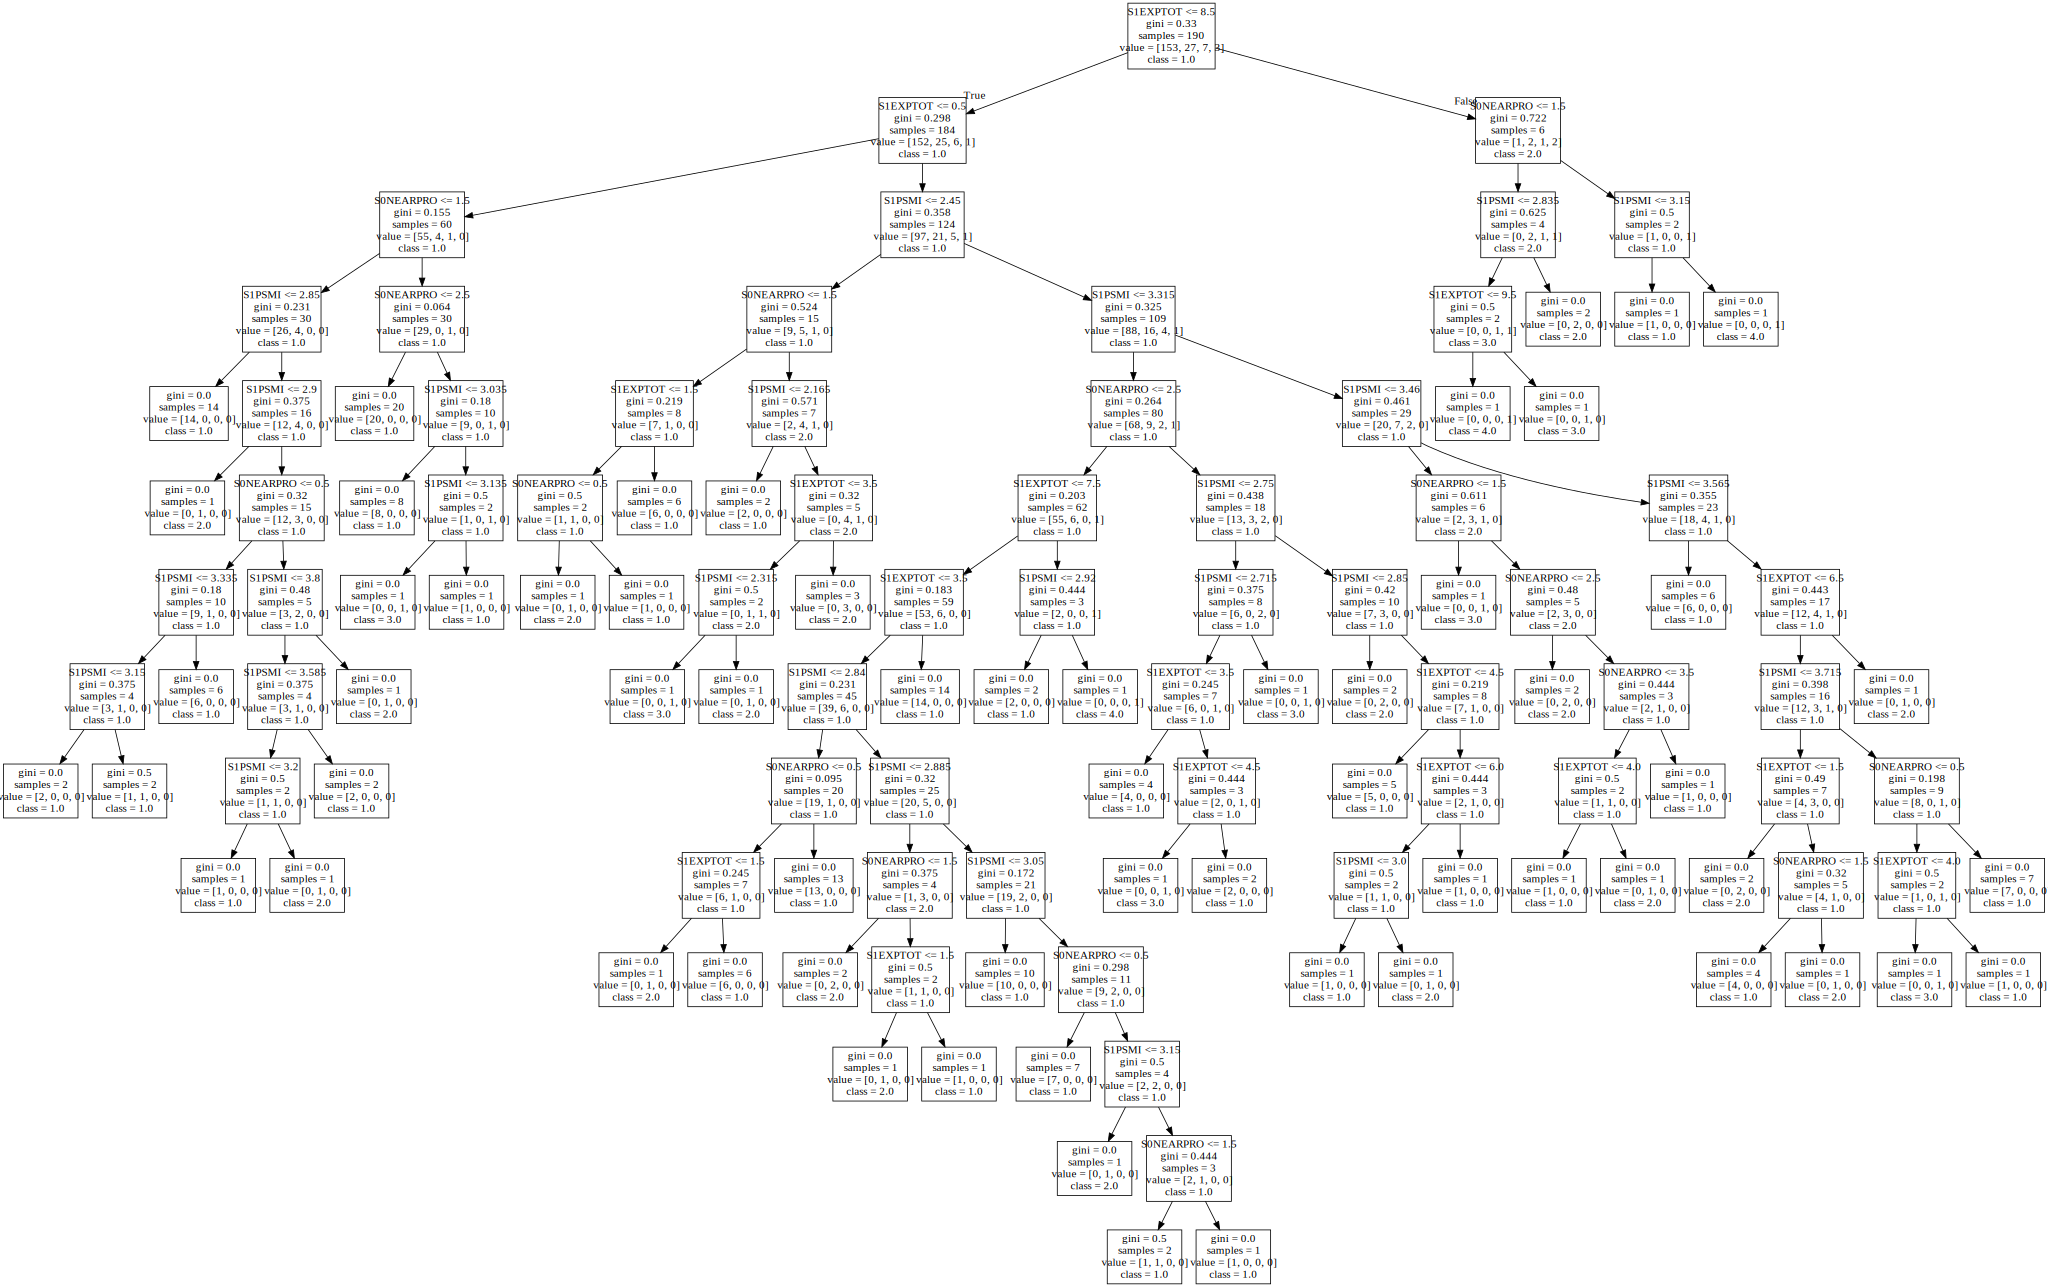

In [27]:
## Decision Tree Select Model Rendering - 6-month cohort
dot_data = tree.export_graphviz(selectmodelS1, out_file=None,
                               feature_names=XselectS1.columns,
                               class_names=np.sort(PolConSelectS1.unique()))
                               #class_names=PolConSelect)
                               #class_names=['0','1','2','3','4'])
                               #class_names=True)
graph = gv.Source(dot_data)
graph.render("SelectModelS1")
graph

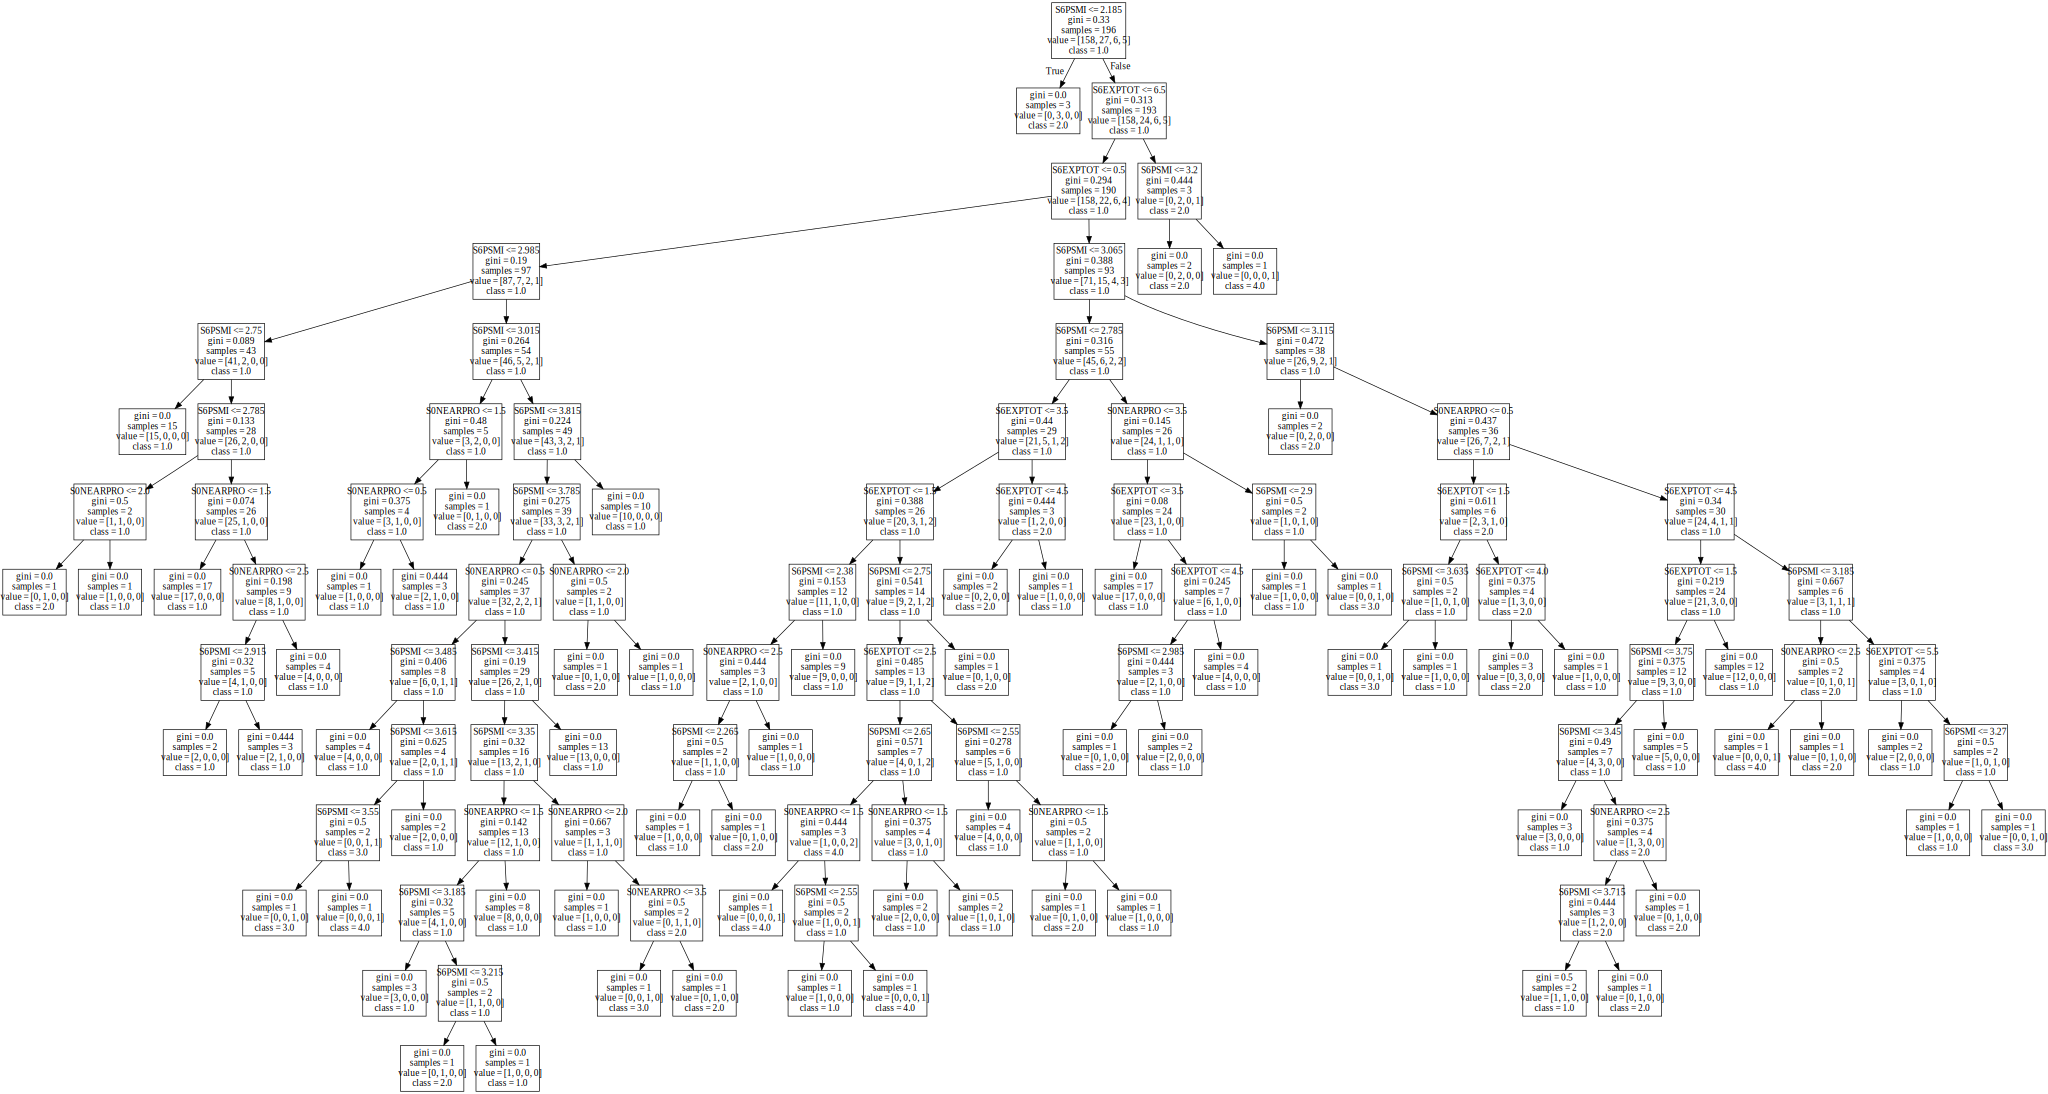

In [28]:
## Decision Tree Select Model Rendering - 36-month cohort
dot_data = tree.export_graphviz(selectmodelS6, out_file=None,
                               feature_names=XselectS6.columns,
                               class_names=np.sort(PolConSelectS6.unique()))
                               #class_names=PolConSelect)
                               #class_names=['0','1','2','3','4'])
                               #class_names=True)
graph = gv.Source(dot_data)
graph.render("SelectModelS6")
graph

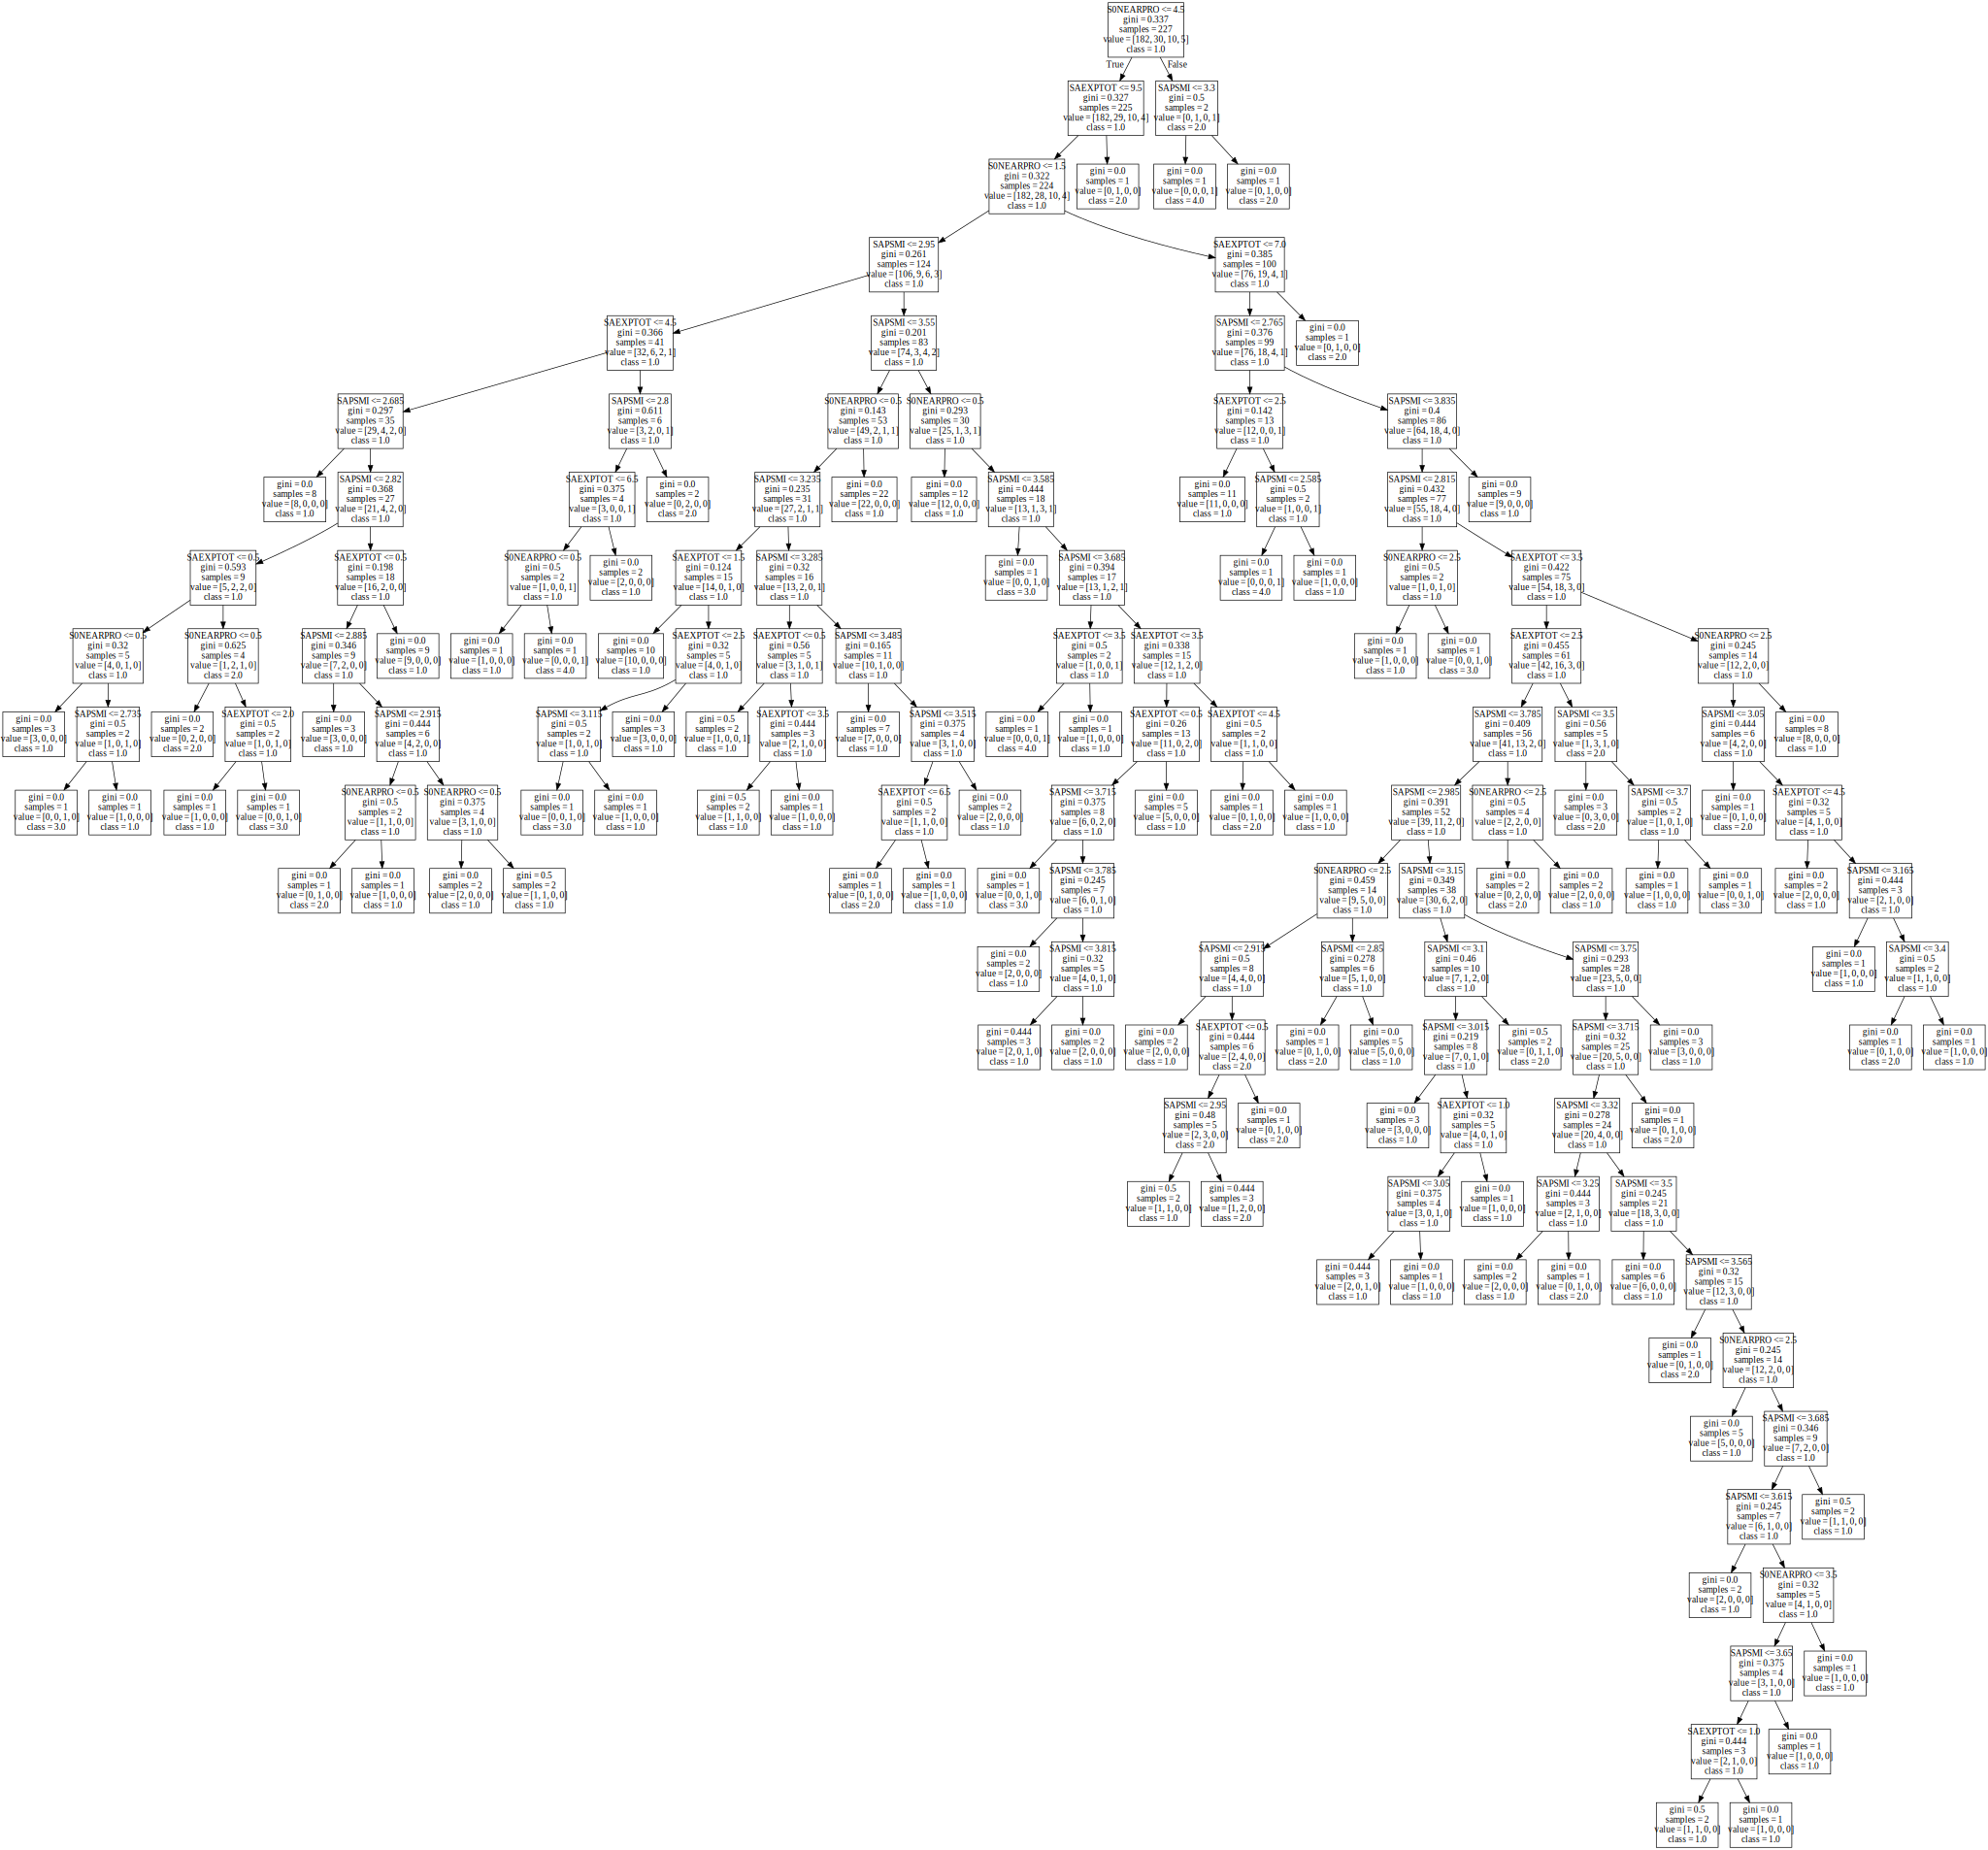

In [29]:
## Decision Tree Select Model Rendering - 84-month cohort
dot_data = tree.export_graphviz(selectmodelSA, out_file=None,
                               feature_names=XselectSA.columns,
                               class_names=np.sort(PolConSelectSA.unique()))
                               #class_names=PolConSelect)
                               #class_names=['0','1','2','3','4'])
                               #class_names=True)
graph = gv.Source(dot_data)
graph.render("SelectModelSA")
graph

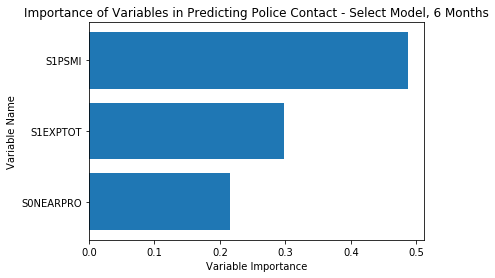

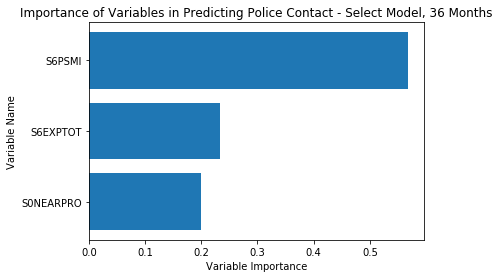

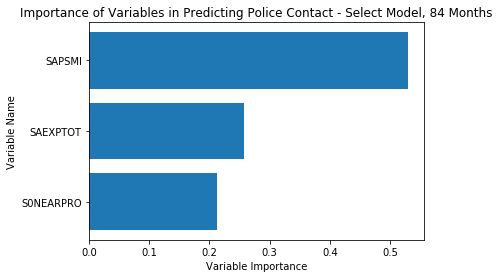

In [30]:
# Feature Importance Graphs - Select Model Decision Trees

featimpbar(selectmodelS1, XselectS1, 'Importance of Variables in Predicting Police Contact - Select Model, 6 Months')
featimpbar(selectmodelS6, XselectS6, 'Importance of Variables in Predicting Police Contact - Select Model, 36 Months')
featimpbar(selectmodelSA, XselectSA, 'Importance of Variables in Predicting Police Contact - Select Model, 84 Months')


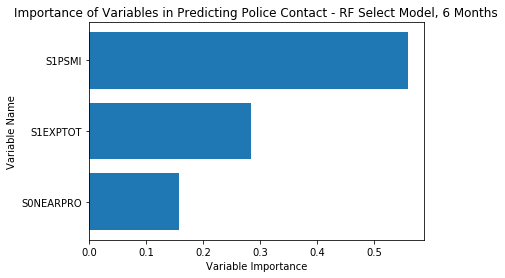

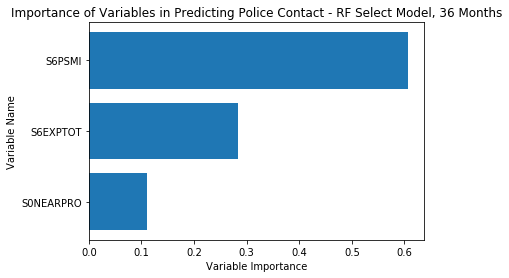

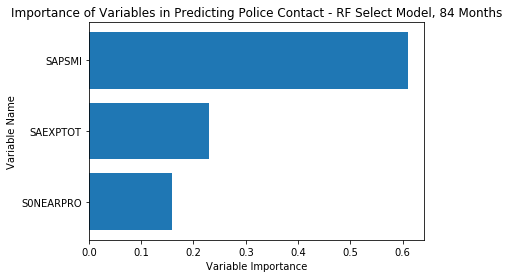

In [31]:
# Feature Importance Graphs - Random Forest Model, Select Model

featimpbar(randomselectS1, XselectS1, 'Importance of Variables in Predicting Police Contact - RF Select Model, 6 Months')
featimpbar(randomselectS6, XselectS6, 'Importance of Variables in Predicting Police Contact - RF Select Model, 36 Months')
featimpbar(randomselectSA, XselectSA, 'Importance of Variables in Predicting Police Contact - RF Select Model, 84 Months')
